In [68]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

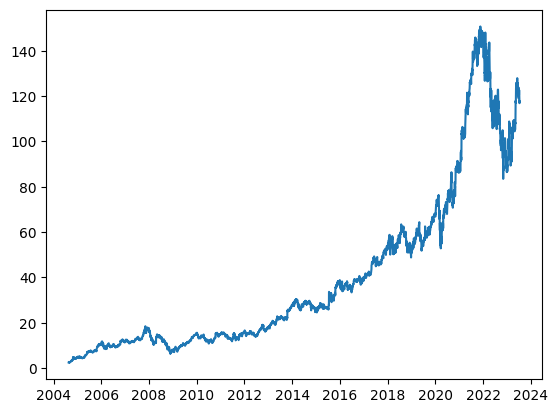

In [69]:
# Dataset is downloaded from https://finance.yahoo.com/quote/GOOG/history?p=GOOG
# df = pd.read_csv("GOOG.csv")
# or
df = pd.read_csv(r"https://raw.githubusercontent.com/imagineacreativeusername/bharat-intern-data-science-task-1/main/GOOG.csv")[['Date', 'Close']]

str_to_datetime = lambda d : datetime.datetime(*map(int, d.split('-')))
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

plt.plot(df.index, df['Close'])
plt.show()

In [70]:

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,101.929497,102.648003,102.252998,102.218002
1,2021-03-26,102.648003,102.252998,102.218002,101.777496
2,2021-03-29,102.252998,102.218002,101.777496,102.797501
3,2021-03-30,102.218002,101.777496,102.797501,102.777000
4,2021-03-31,101.777496,102.797501,102.777000,103.431503
...,...,...,...,...,...
247,2022-03-17,126.740997,129.660507,133.690506,134.600494
248,2022-03-18,129.660507,133.690506,134.600494,136.801498
249,2022-03-21,133.690506,134.600494,136.801498,136.478500
250,2022-03-22,134.600494,136.801498,136.478500,140.277496


In [71]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

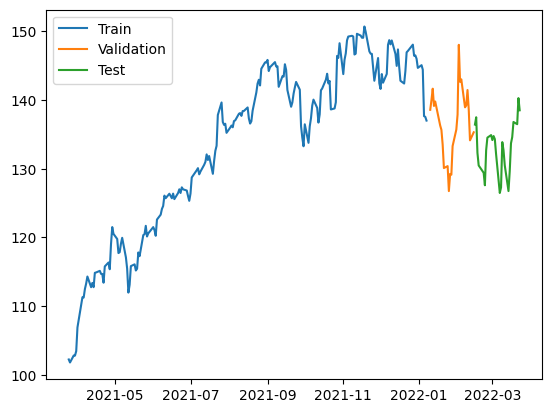

In [72]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 149ms/step - loss: 17929.9805 - mean_absolute_error: 133.3163 - val_loss: 18598.1719 - val_mean_absolute_error: 136.2833
Epoch 2/100
7/7 [==============================] - 0s 18ms/step - loss: 17751.1445 - mean_absolute_error: 132.6457 - val_loss: 18447.5215 - val_mean_absolute_error: 135.7295
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 17611.9102 - mean_absolute_error: 132.1188 - val_loss: 18313.0039 - val_mean_absolute_error: 135.2330
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 17479.3203 - mean_absolute_error: 131.6152 - val_loss: 18167.2578 - val_mean_absolute_error: 134.6930
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 17320.6836 - mean_absolute_error: 131.0103 - val_loss: 17967.8594 - val_mean_absolute_error: 133.9506
Epoch 6/100
7/7 [==============================] - 0s 17ms/step - loss: 17098.9922 - mean_absolute_error: 130.1602 - val_loss: 17

7/7 [==============================] - 1s 3ms/step


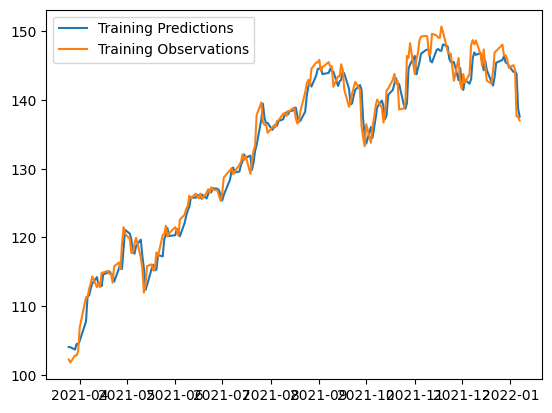

In [74]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 29ms/step


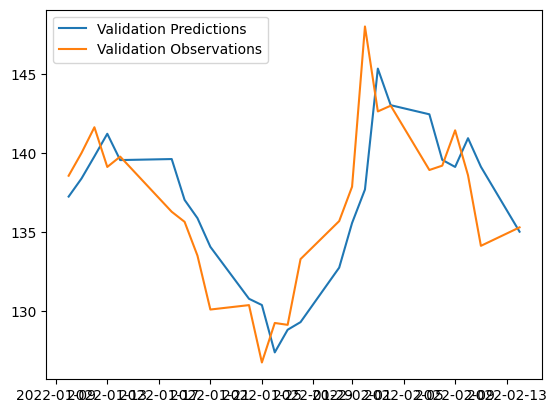

In [75]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 26ms/step


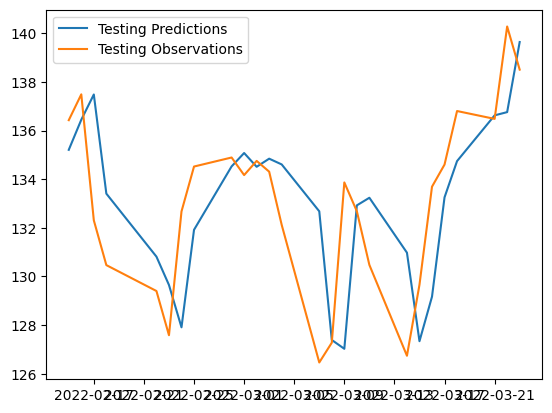

In [76]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

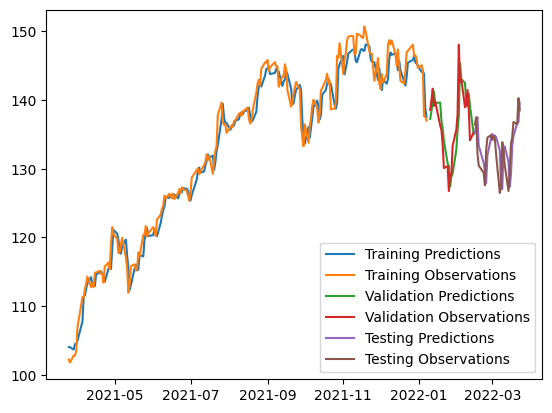

In [77]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])